In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

In [2]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence

class Dataloader(Sequence):
    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.expand_dims(np.array(batch_x), -1), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [3]:
data_train, data_test = tf.keras.datasets.mnist.load_data()

In [6]:
batch_size = 50
(images_train, labels_train) = data_train
(images_test, labels_test) = data_test
images_train, images_test = images_train / 255.0, images_test / 255.0
labels_train = np.eye(10)[labels_train]
labels_test = np.eye(10)[labels_test]
train_loader = Dataloader(images_train, labels_train, batch_size, shuffle=True)
test_loader = Dataloader(images_test, labels_test, batch_size)

In [7]:
from itertools import product
class cnn_Layer(tf.keras.layers.Layer):
    def __init__(
        self,
        img_size,
        input_channel,
        output_channel,
        kernel_size,
    ):
        super().__init__()
        
        tf_initializer = tf.random_normal_initializer()
        
        self.output_channel = output_channel
        self.kernel_size = (kernel_size, kernel_size)
        self.pad_size = kernel_size // 2
        
        self.n_samples = None
        self.width = None
        self.height = None

        self.weight = tf.Variable(tf_initializer((output_channel, kernel_size, kernel_size, input_channel)))
        self.bias = tf.Variable(tf_initializer((output_channel,)))
        
    # pad image
    def _add_pad(self, img):
        self.n_samples, self.width, self.height, _ = img.shape
        return tf.pad(img,[[0,0],[1,1],[1,1],[0,0]])
    
    # sliced image
    def _slicing(self, img):
        # product는 뒤에 있는게 먼저 작동함
        n_samples, width, height, channel = img.shape
        stack = [
            img[
                :,
                w:w+self.kernel_size[0],
                h:h+self.kernel_size[1],
                :
            ] for w,h in product(
                range(width - self.kernel_size[0] + 1), 
                range(height - self.kernel_size[1] + 1)
            )
        ]
        return tf.stack(stack, axis=-1)
    
    # weight product
    def _weight_product(self, features):
        stack = []
        for n in range(self.output_channel):
            w = self.weight[n]
            stack.append(tf.math.multiply(tf.expand_dims(tf.expand_dims(w, 0),-1), features))
        stack = tf.stack(stack,-1)
        stack = tf.reduce_sum(stack, [1,2,3])
        stack = tf.reshape(stack, [self.n_samples, self.width, self.height, self.output_channel])
        stack = tf.add(stack, self.bias)
        return stack
    
    def __call__(self, img):
        pad_img = self._add_pad(img)
        sliced_img = self._slicing(pad_img)
        features = self._weight_product(sliced_img)
        return features

In [14]:
class CNN(tf.keras.Model):
    def __init__(self, img_shape, channel_lists, kernel_size, n_class = 10):
        super().__init__()
        
        self.channel_lists = channel_lists
        
        self.cnn_layers = [
            cnn_Layer(img_shape, i, o, kernel_size) for i,o in zip(channel_lists, channel_lists[1:])
        ]
        
        self.batch_layers = [
            tf.keras.layers.BatchNormalization() for o in channel_lists[1:]
        ]
        
        self.output_layers = tf.keras.layers.Dense(n_class, activation='relu')
        self.a = tf.keras.layers.ReLU()
        self.d = tf.keras.layers.Dropout(.3)

    # @tf.function
    def call(self, img, training = True):
        x = tf.cast(img, tf.float32)
        
        for l,b in zip(self.cnn_layers, self.batch_layers):
            x = tf.transpose(l(x), perm=[0,3,1,2])
            x = tf.transpose(b(x), perm=[0,2,3,1])
            x = self.a(x)
            x = self.d(x, training)        
        
        x = tf.reshape(x, [img.shape[0], -1, self.channel_lists[-1]])
        x = tf.reduce_max(x, axis=1)
        
        return tf.nn.softmax(self.output_layers(x),-1)
    
    def layer_maps(self, img):
        maps = []
        x = img
        for l,b in zip(self.cnn_layers, self.batch_layers):
            x = tf.transpose(l(x), perm=[0,3,1,2])
            maps.append(x)
            x = tf.transpose(b(x), perm=[0,2,3,1])
            x = self.a(x)
            x = self.d(x, training)
        return maps

In [15]:
class tf_trainer:
    def __init__(self, model, data_loader):
        self.model = model
        self.data_loader = data_loader
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        
    def __training_batch_step__(self, batch):
        x,y = batch
        with tf.GradientTape() as t:
            y_hat = self.model(x, training = True)
            loss = self.loss_fn(y, y_hat)
        grad = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        return loss

    def __training_epoch__(self, epoch_numb):
        loss_lists = []
        TQ = tqdm(self.data_loader)
        for n, batch in enumerate(TQ,1):
            loss_lists.append(self.__training_batch_step__(batch))
            TQ.set_description_str(f'Epoch : {epoch_numb}')
            TQ.set_postfix_str(f'Loss : {sum(loss_lists) / n:.5}')
        return sum(loss_lists) / n
    
    def fit(self, loop_numb):
        history = dict(
            loss = []
        )
        for n in range(loop_numb):
            history['loss'].append(
                self.__training_epoch__(n)
            )
        return history

In [16]:
tf_dicts = dict(
    img_shape = 28,
    channel_lists = [1, 8, 16, 32],
    kernel_size = 3,
)

In [17]:
manual_tf_model = CNN(**tf_dicts)

In [18]:
trainer = tf_trainer(manual_tf_model, train_loader)

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

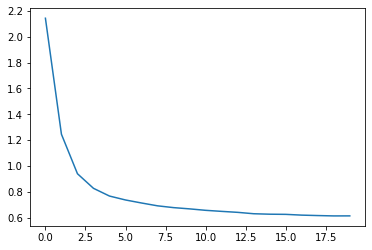

In [19]:
plt.plot(trainer.fit(20)['loss'])